## CTGAN 모듈 사용하기

In [ ]:
!pip install ctgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 949.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux

In [ ]:
from ctgan import CTGAN
from ctgan import load_demo

In [ ]:
# "Adult Income Dataset"
real_data = load_demo()

# Names of the columns that are discrete
discrete_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
]

ctgan = CTGAN(epochs=10)
ctgan.fit(real_data, discrete_columns)

# Create synthetic data
synthetic_data = ctgan.sample(1000)

In [ ]:
import pandas as pd

# 합성 데이터를 판다스 DataFrame으로 변환
synthetic_df = pd.DataFrame(synthetic_data, columns=real_data.columns)

# 합성된 데이터의 일부를 출력
print(synthetic_df.head(10))

   age     workclass  fnlwgt      education  education-num  \
0   49       Private  312516      Bachelors             13   
1   37       Private  122013      Assoc-voc             10   
2   50   Federal-gov  136222   Some-college              2   
3   34       Private  174860   Some-college              9   
4   51   Federal-gov  174357           11th             13   
5   47             ?  101299           12th              6   
6   52       Private  245132   Some-college             10   
7   47       Private  243346   Some-college              3   
8   25       Private  151789           11th             14   
9   31       Private  156609           10th              8   

           marital-status          occupation    relationship  \
0   Married-spouse-absent   Machine-op-inspct         Husband   
1                Divorced     Farming-fishing            Wife   
2                 Widowed      Prof-specialty   Not-in-family   
3                 Widowed     Exec-managerial         Hus

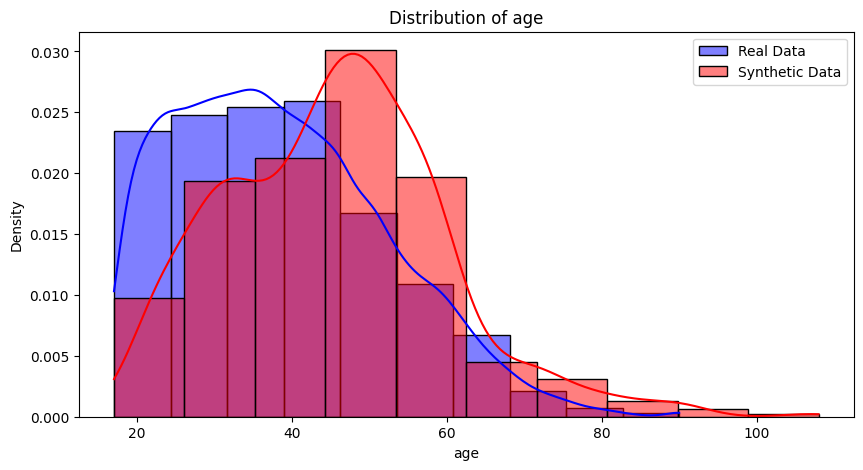

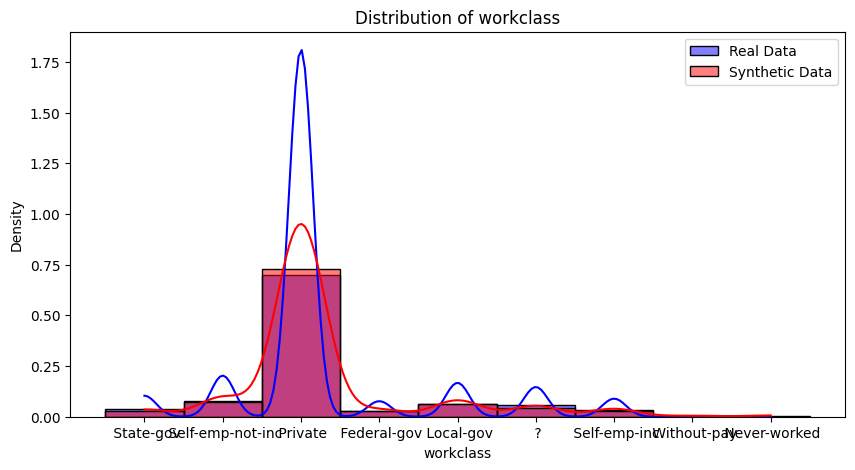

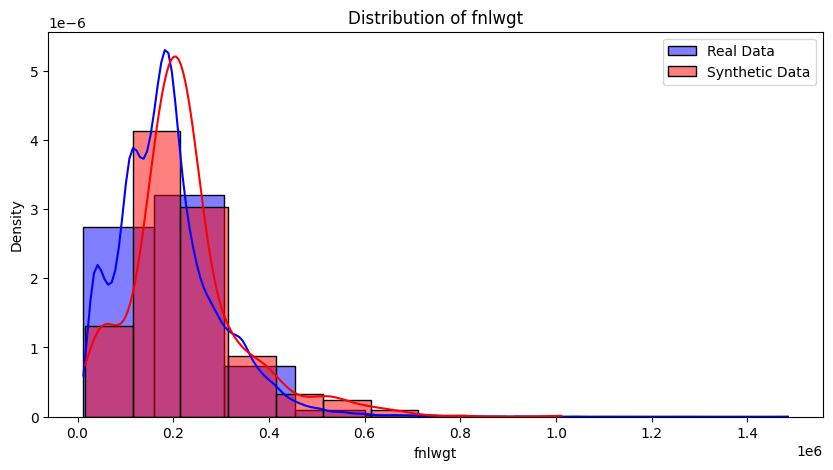

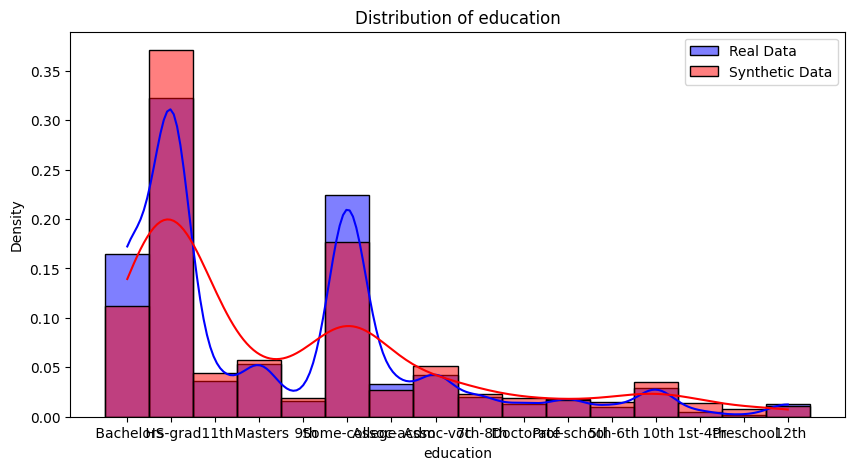

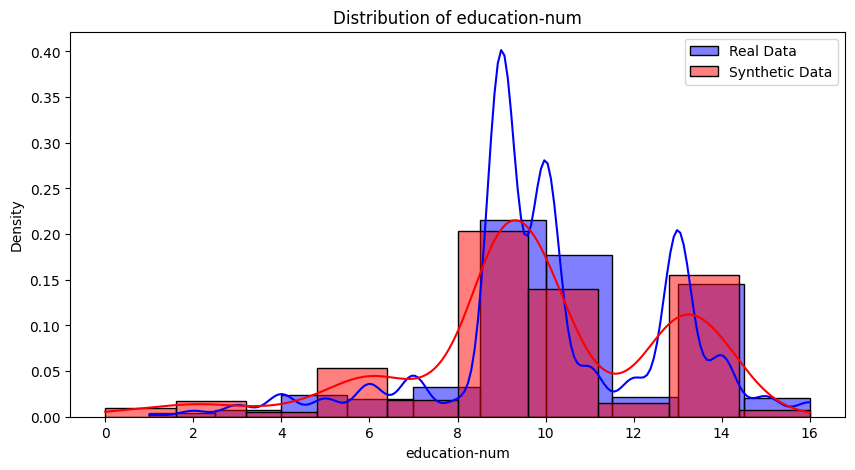

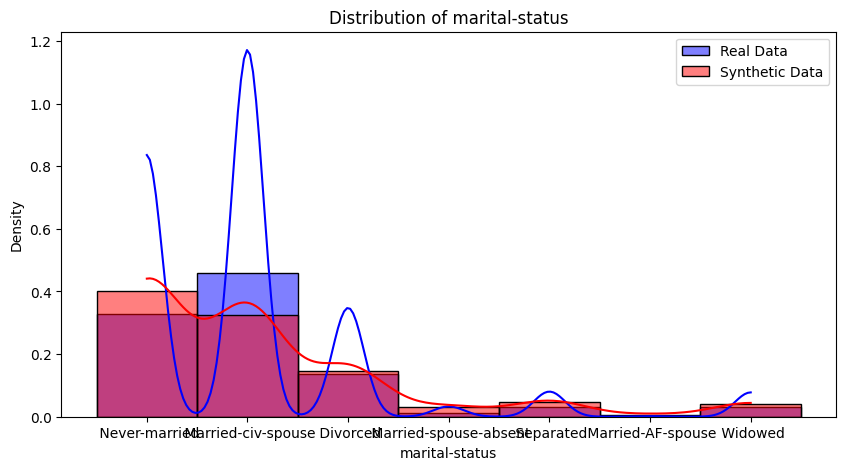

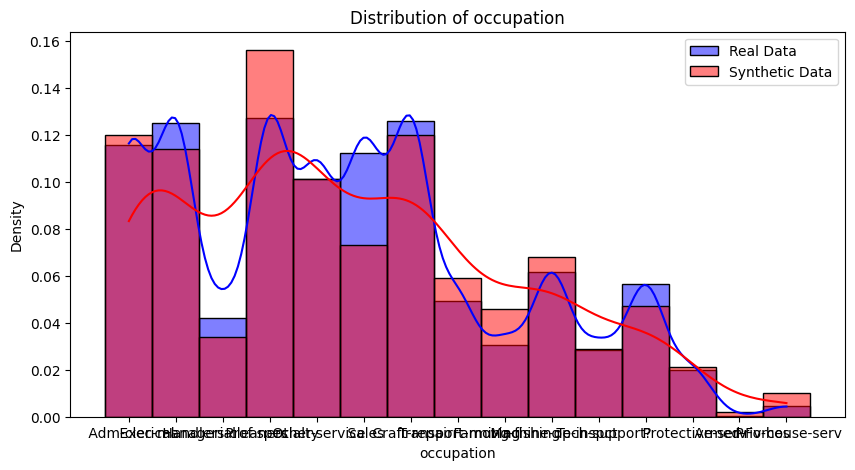

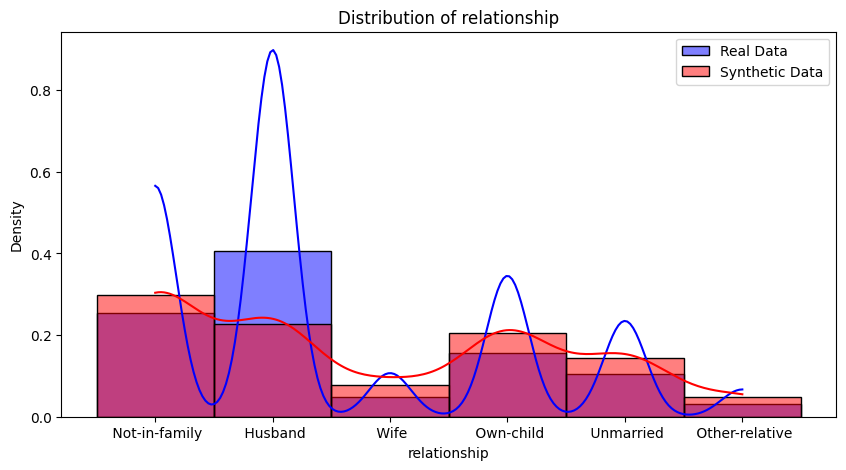

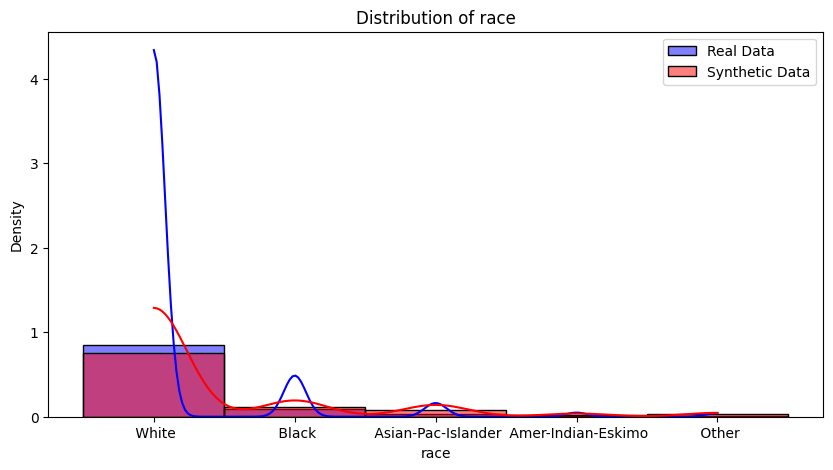

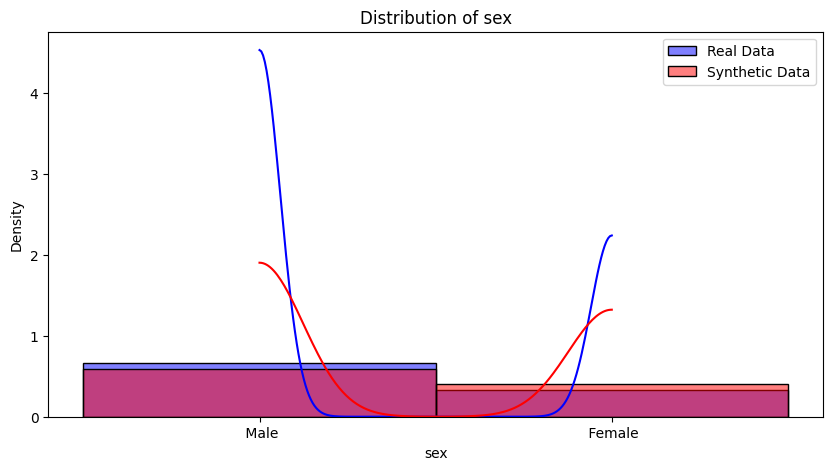

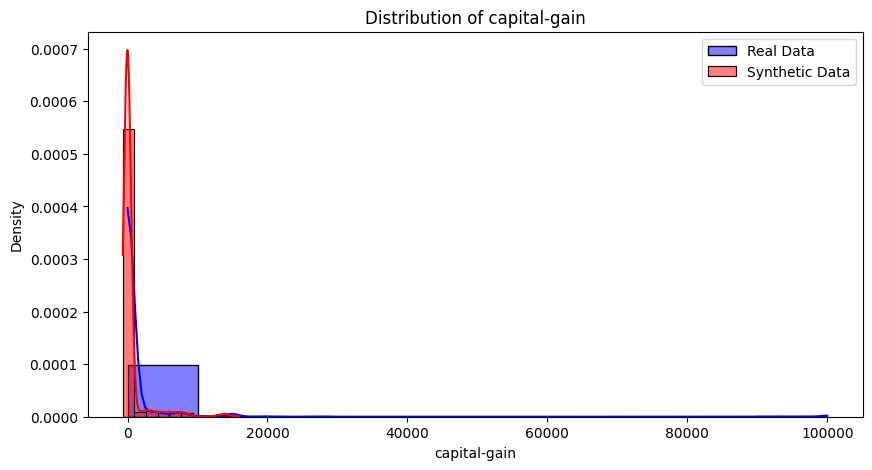

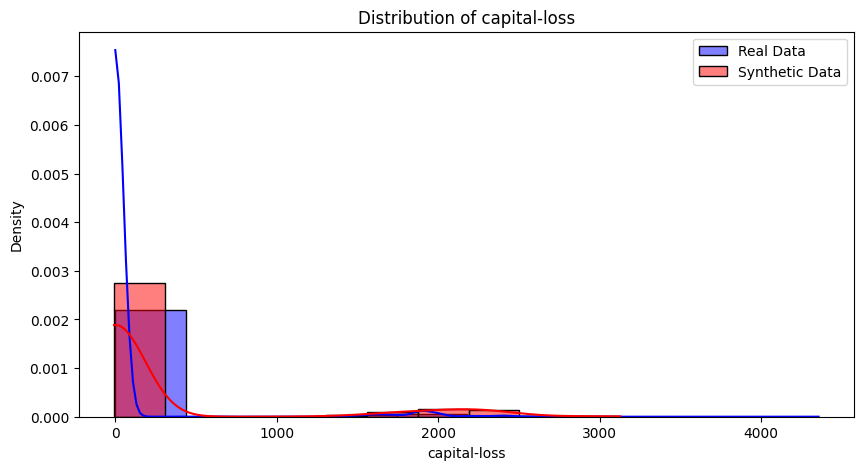

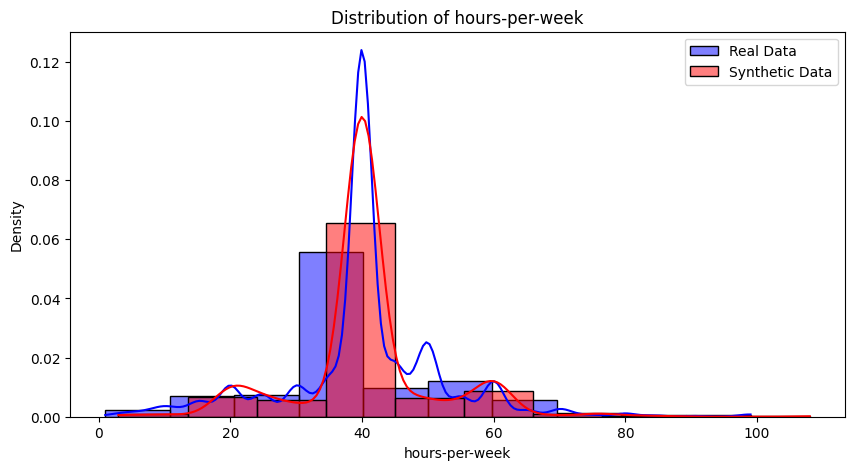

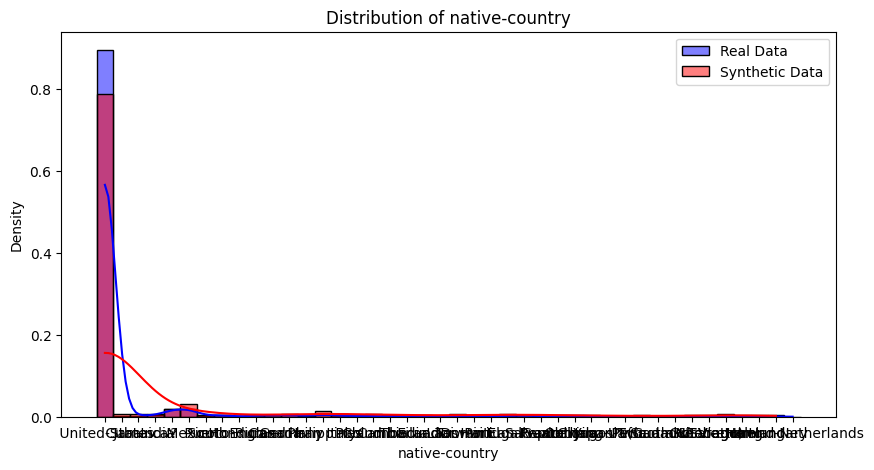

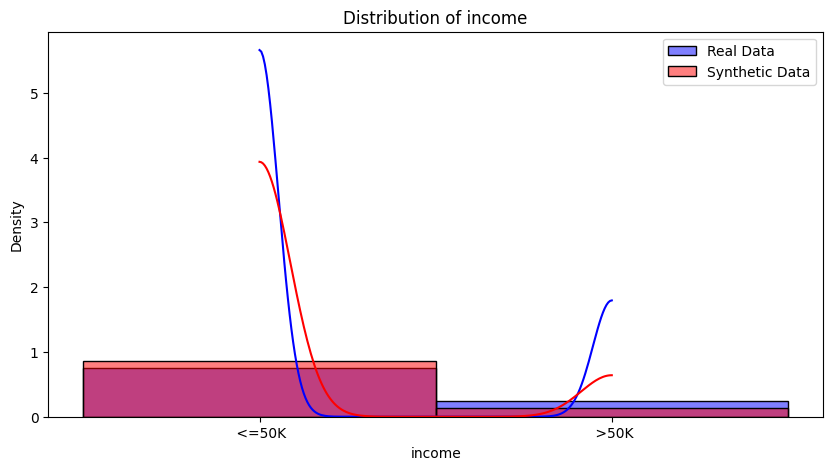

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 원본 데이터와 합성 데이터의 분포를 비교하는 함수
def compare_distributions(real_data, synthetic_data, columns, num_bins=10):
    for column in columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(real_data[column], bins=num_bins, color='blue', label='Real Data', kde=True, stat='density')
        sns.histplot(synthetic_data[column], bins=num_bins, color='red', label='Synthetic Data', kde=True, stat='density')
        plt.legend()
        plt.title(f'Distribution of {column}')
        plt.show()


# 합성 데이터를 판다스 DataFrame으로 변환
synthetic_df = pd.DataFrame(synthetic_data, columns=real_data.columns)

# 분포 비교
compare_distributions(real_data, synthetic_df,  real_data.columns)


In [ ]:
import numpy as np
from scipy.stats import entropy


columns_to_compare = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
# Kullback-Leibler 다이버전스를 계산하는 함수
def calculate_kl_divergence(real_data, synthetic_data, columns, num_bins=10):
    kl_divergence = {}
    for column in columns:
        real_hist, bin_edges = np.histogram(real_data[column], bins=num_bins, density=True)
        synth_hist, _ = np.histogram(synthetic_data[column], bins=bin_edges, density=True)
        kl_divergence[column] = entropy(real_hist, synth_hist)
    return kl_divergence

# KL 다이버전스 계산
kl_divergence = calculate_kl_divergence(real_data, synthetic_df, columns_to_compare)
print("KL Divergence for each column:")
print(kl_divergence)


KL Divergence for each column:
{'age': 0.1387322337874712, 'education-num': 0.04317158791082552, 'hours-per-week': inf, 'capital-gain': inf, 'capital-loss': inf}


## CTGAN 구현하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.csv, tsv 파일로 읽고 저장하기

In [2]:
import json

import numpy as np
import pandas as pd


def read_csv(csv_filename, meta_filename=None, header=True, discrete=None):
    """Read a csv file."""
    data = pd.read_csv(csv_filename, header='infer' if header else None)

    if meta_filename:
        with open(meta_filename) as meta_file:
            metadata = json.load(meta_file)

        discrete_columns = [
            column['name'] for column in metadata['columns'] if column['type'] != 'continuous'
        ]

    elif discrete:
        discrete_columns = discrete.split(',')
        if not header:
            discrete_columns = [int(i) for i in discrete_columns]

    else:
        discrete_columns = []

    return data, discrete_columns


def read_tsv(data_filename, meta_filename):
    """Read a tsv file."""
    with open(meta_filename) as f:
        column_info = f.readlines()

    column_info_raw = [x.replace('{', ' ').replace('}', ' ').split() for x in column_info]

    discrete = []
    continuous = []
    column_info = []

    for idx, item in enumerate(column_info_raw):
        if item[0] == 'C':
            continuous.append(idx)
            column_info.append((float(item[1]), float(item[2])))
        else:
            assert item[0] == 'D'
            discrete.append(idx)
            column_info.append(item[1:])

    meta = {
        'continuous_columns': continuous,
        'discrete_columns': discrete,
        'column_info': column_info,
    }

    with open(data_filename) as f:
        lines = f.readlines()

    data = []
    for row in lines:
        row_raw = row.split()
        row = []
        for idx, col in enumerate(row_raw):
            if idx in continuous:
                row.append(col)
            else:
                assert idx in discrete
                row.append(column_info[idx].index(col))

        data.append(row)

    return np.asarray(data, dtype='float32'), meta['discrete_columns']


def write_tsv(data, meta, output_filename):
    """Write to a tsv file."""
    with open(output_filename, 'w') as f:
        for row in data:
            for idx, col in enumerate(row):
                if idx in meta['continuous_columns']:
                    print(col, end=' ', file=f)
                else:
                    assert idx in meta['discrete_columns']
                    print(meta['column_info'][idx][int(col)], end=' ', file=f)

            print(file=f)

2.data transformer : 데이터셋의 이산형 및 연속형 열을 각각 적절한 방식으로 변환하고, 이를 모델 학습에 사용할 수 있도록 변환된 데이터를 제공하는 역할 &  변환된 데이터를 원래 형태로 복원하는 기능도 제공

In [4]:
! pip install rdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:00


In [5]:
from collections import namedtuple

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from rdt.transformers import ClusterBasedNormalizer, OneHotEncoder

SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo',
    ['column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'],
)


class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalize them to a scalar between [-1, 1]
    and a vector. Discrete columns are encoded using a OneHotEncoder.
    """

    def __init__(self, max_clusters=10, weight_threshold=0.005):
        """Create a data transformer.

        Args:
            max_clusters (int):
                Maximum number of Gaussian distributions in Bayesian GMM.
            weight_threshold (float):
                Weight threshold for a Gaussian distribution to be kept.
        """
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        """Train Bayesian GMM for continuous columns.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        gm = ClusterBasedNormalizer(
            missing_value_generation='from_column',
            max_clusters=min(len(data), self._max_clusters),
            weight_threshold=self._weight_threshold,
        )
        gm.fit(data, column_name)
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='continuous',
            transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components,
        )

    def _fit_discrete(self, data):
        """Fit one hot encoder for discrete column.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        ohe = OneHotEncoder()
        ohe.fit(data, column_name)
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='discrete',
            transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories,
        )

    def fit(self, raw_data, discrete_columns=()):
        """Fit the ``DataTransformer``.

        Fits a ``ClusterBasedNormalizer`` for continuous columns and a
        ``OneHotEncoder`` for discrete columns.

        This step also counts the #columns in matrix data and span information.
        """
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        flattened_column = data[column_name].to_numpy().flatten()
        data = data.assign(**{column_name: flattened_column})
        gm = column_transform_info.transform
        transformed = gm.transform(data)

        #  Converts the transformed data to the appropriate output format.
        #  The first column (ending in '.normalized') stays the same,
        #  but the lable encoded column (ending in '.component') is one hot encoded.
        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def _synchronous_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns synchronous.

        Outputs a list with Numpy arrays.
        """
        column_data_list = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return column_data_list

    def _parallel_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns in parallel.

        Outputs a list with Numpy arrays.
        """
        processes = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            process = None
            if column_transform_info.column_type == 'continuous':
                process = delayed(self._transform_continuous)(column_transform_info, data)
            else:
                process = delayed(self._transform_discrete)(column_transform_info, data)
            processes.append(process)

        return Parallel(n_jobs=-1)(processes)

    def transform(self, raw_data):
        """Take raw data and output a matrix data."""
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        # Only use parallelization with larger data sizes.
        # Otherwise, the transformation will be slower.
        if raw_data.shape[0] < 500:
            column_data_list = self._synchronous_transform(
                raw_data, self._column_transform_info_list
            )
        else:
            column_data_list = self._parallel_transform(raw_data, self._column_transform_info_list)

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_sdtypes())).astype(float)
        data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data)

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_sdtypes()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        """Take matrix data and output raw data.

        Output uses the same type as input to the transform function.
        Either np array or pd dataframe.
        """
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st : st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st
                )
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data
                )

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = pd.DataFrame(recovered_data, columns=column_names).astype(
            self._column_raw_dtypes
        )
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        """Get the ids of the given `column_name`."""
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot),
        }

data sampling 코드

In [6]:
"""DataSampler module."""

import numpy as np


class DataSampler(object):
    """DataSampler samples the conditional vector and corresponding data for CTGAN."""

    def __init__(self, data, output_info, log_frequency):
        self._data_length = len(data)

        def is_discrete_column(column_info):
            return len(column_info) == 1 and column_info[0].activation_fn == 'softmax'

        n_discrete_columns = sum([
            1 for column_info in output_info if is_discrete_column(column_info)
        ])

        self._discrete_column_matrix_st = np.zeros(n_discrete_columns, dtype='int32')

        # Store the row id for each category in each discrete column.
        # For example _rid_by_cat_cols[a][b] is a list of all rows with the
        # a-th discrete column equal value b.
        self._rid_by_cat_cols = []

        # Compute _rid_by_cat_cols
        st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim

                rid_by_cat = []
                for j in range(span_info.dim):
                    rid_by_cat.append(np.nonzero(data[:, st + j])[0])
                self._rid_by_cat_cols.append(rid_by_cat)
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])
        assert st == data.shape[1]

        # Prepare an interval matrix for efficiently sample conditional vector
        max_category = max(
            [column_info[0].dim for column_info in output_info if is_discrete_column(column_info)],
            default=0,
        )

        self._discrete_column_cond_st = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_n_category = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_category_prob = np.zeros((n_discrete_columns, max_category))
        self._n_discrete_columns = n_discrete_columns
        self._n_categories = sum([
            column_info[0].dim for column_info in output_info if is_discrete_column(column_info)
        ])

        st = 0
        current_id = 0
        current_cond_st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim
                category_freq = np.sum(data[:, st:ed], axis=0)
                if log_frequency:
                    category_freq = np.log(category_freq + 1)
                category_prob = category_freq / np.sum(category_freq)
                self._discrete_column_category_prob[current_id, : span_info.dim] = category_prob
                self._discrete_column_cond_st[current_id] = current_cond_st
                self._discrete_column_n_category[current_id] = span_info.dim
                current_cond_st += span_info.dim
                current_id += 1
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])

    def _random_choice_prob_index(self, discrete_column_id):
        probs = self._discrete_column_category_prob[discrete_column_id]
        r = np.expand_dims(np.random.rand(probs.shape[0]), axis=1)
        return (probs.cumsum(axis=1) > r).argmax(axis=1)

    def sample_condvec(self, batch):
        """Generate the conditional vector for training.

        Returns:
            cond (batch x #categories):
                The conditional vector.
            mask (batch x #discrete columns):
                A one-hot vector indicating the selected discrete column.
            discrete column id (batch):
                Integer representation of mask.
            category_id_in_col (batch):
                Selected category in the selected discrete column.
        """
        if self._n_discrete_columns == 0:
            return None

        discrete_column_id = np.random.choice(np.arange(self._n_discrete_columns), batch)

        cond = np.zeros((batch, self._n_categories), dtype='float32')
        mask = np.zeros((batch, self._n_discrete_columns), dtype='float32')
        mask[np.arange(batch), discrete_column_id] = 1
        category_id_in_col = self._random_choice_prob_index(discrete_column_id)
        category_id = self._discrete_column_cond_st[discrete_column_id] + category_id_in_col
        cond[np.arange(batch), category_id] = 1

        return cond, mask, discrete_column_id, category_id_in_col

    def sample_original_condvec(self, batch):
        """Generate the conditional vector for generation use original frequency."""
        if self._n_discrete_columns == 0:
            return None

        category_freq = self._discrete_column_category_prob.flatten()
        category_freq = category_freq[category_freq != 0]
        category_freq = category_freq / np.sum(category_freq)
        col_idxs = np.random.choice(np.arange(len(category_freq)), batch, p=category_freq)
        cond = np.zeros((batch, self._n_categories), dtype='float32')
        cond[np.arange(batch), col_idxs] = 1

        return cond

    def sample_data(self, data, n, col, opt):
        """Sample data from original training data satisfying the sampled conditional vector.

        Args:
            data:
                The training data.

        Returns:
            n:
                n rows of matrix data.
        """
        if col is None:
            idx = np.random.randint(len(data), size=n)
            return data[idx]

        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self._rid_by_cat_cols[c][o]))

        return data[idx]

    def dim_cond_vec(self):
        """Return the total number of categories."""
        return self._n_categories

    def generate_cond_from_condition_column_info(self, condition_info, batch):
        """Generate the condition vector."""
        vec = np.zeros((batch, self._n_categories), dtype='float32')
        id_ = self._discrete_column_matrix_st[condition_info['discrete_column_id']]
        id_ += condition_info['value_id']
        vec[:, id_] = 1
        return vec

3.base class : 랜덤 상태 관리, 객체의 직렬화 및 역직렬화, 모델 저장 및 불러오기 등의 기능을 제공

In [7]:
import contextlib

import numpy as np
import torch


@contextlib.contextmanager
def set_random_states(random_state, set_model_random_state):
    """Context manager for managing the random state.

    Args:
        random_state (int or tuple):
            The random seed or a tuple of (numpy.random.RandomState, torch.Generator).
        set_model_random_state (function):
            Function to set the random state on the model.
    """
    original_np_state = np.random.get_state()
    original_torch_state = torch.get_rng_state()

    random_np_state, random_torch_state = random_state

    np.random.set_state(random_np_state.get_state())
    torch.set_rng_state(random_torch_state.get_state())

    try:
        yield
    finally:
        current_np_state = np.random.RandomState()
        current_np_state.set_state(np.random.get_state())
        current_torch_state = torch.Generator()
        current_torch_state.set_state(torch.get_rng_state())
        set_model_random_state((current_np_state, current_torch_state))

        np.random.set_state(original_np_state)
        torch.set_rng_state(original_torch_state)


def random_state(function):
    """Set the random state before calling the function.

    Args:
        function (Callable):
            The function to wrap around.
    """

    def wrapper(self, *args, **kwargs):
        if self.random_states is None:
            return function(self, *args, **kwargs)

        else:
            with set_random_states(self.random_states, self.set_random_state):
                return function(self, *args, **kwargs)

    return wrapper


class BaseSynthesizer:
    """Base class for all default synthesizers of ``CTGAN``."""

    random_states = None

    def __getstate__(self):
        """Improve pickling state for ``BaseSynthesizer``.

        Convert to ``cpu`` device before starting the pickling process in order to be able to
        load the model even when used from an external tool such as ``SDV``. Also, if
        ``random_states`` are set, store their states as dictionaries rather than generators.

        Returns:
            dict:
                Python dict representing the object.
        """
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        state = self.__dict__.copy()
        self.set_device(device_backup)
        if (
            isinstance(self.random_states, tuple)
            and isinstance(self.random_states[0], np.random.RandomState)
            and isinstance(self.random_states[1], torch.Generator)
        ):
            state['_numpy_random_state'] = self.random_states[0].get_state()
            state['_torch_random_state'] = self.random_states[1].get_state()
            state.pop('random_states')

        return state

    def __setstate__(self, state):
        """Restore the state of a ``BaseSynthesizer``.

        Restore the ``random_states`` from the state dict if those are present and then
        set the device according to the current hardware.
        """
        if '_numpy_random_state' in state and '_torch_random_state' in state:
            np_state = state.pop('_numpy_random_state')
            torch_state = state.pop('_torch_random_state')

            current_torch_state = torch.Generator()
            current_torch_state.set_state(torch_state)

            current_numpy_state = np.random.RandomState()
            current_numpy_state.set_state(np_state)
            state['random_states'] = (current_numpy_state, current_torch_state)

        self.__dict__ = state
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.set_device(device)

    def save(self, path):
        """Save the model in the passed `path`."""
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        torch.save(self, path)
        self.set_device(device_backup)

    @classmethod
    def load(cls, path):
        """Load the model stored in the passed `path`."""
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = torch.load(path)
        model.set_device(device)
        return model

    def set_random_state(self, random_state):
        """Set the random state.

        Args:
            random_state (int, tuple, or None):
                Either a tuple containing the (numpy.random.RandomState, torch.Generator)
                or an int representing the random seed to use for both random states.
        """
        if random_state is None:
            self.random_states = random_state
        elif isinstance(random_state, int):
            self.random_states = (
                np.random.RandomState(seed=random_state),
                torch.Generator().manual_seed(random_state),
            )
        elif (
            isinstance(random_state, tuple)
            and isinstance(random_state[0], np.random.RandomState)
            and isinstance(random_state[1], torch.Generator)
        ):
            self.random_states = random_state
        else:
            raise TypeError(
                f'`random_state` {random_state} expected to be an int or a tuple of '
                '(`np.random.RandomState`, `torch.Generator`)'
            )

4.ctgan 구현하기

In [14]:
import warnings

import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from tqdm import tqdm


class Discriminator(Module):

    def __init__(self, input_dim, discriminator_dim, pac=10): # discriminator_dim : hiddenlayer 차원 목록
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac # 패킹 , 논문에서는 10
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):

        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data) #interpolation 수행

        disc_interpolates = self(interpolates) #Discriminator 통과

        # WGAN-GP 에서는 입력값을 interpolation 한 값, 출력값을 interploation 한 값을 Discriminator에 통과시킨 값
        # Discriminator가 리프시츠 연속성을 만족하도록 유도 ( Discriminator의 출력이 입력에 대해 지나치게 빠르게 변하는 것을 방지 ) , 값이 작은것이 좋은것
        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input_):
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim))


class Residual(Module):

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)


class Generator(Module):
    def __init__(self, embedding_dim, generator_dim, data_dim): # generator_dim : hiddenlayer 차원 목록
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        data = self.seq(input_)
        return data


class CTGAN(BaseSynthesizer):

    def __init__(
        self,
        embedding_dim=128,
        generator_dim=(256, 256),
        discriminator_dim=(256, 256),
        generator_lr=2e-4,
        generator_decay=1e-6,
        discriminator_lr=2e-4,
        discriminator_decay=1e-6,
        batch_size=500,
        discriminator_steps=1,
        log_frequency=True,
        verbose=False,
        epochs=300,
        pac=10,
        cuda=True,
    ):
        assert batch_size % 2 == 0

        self._embedding_dim = embedding_dim
        self._generator_dim = generator_dim
        self._discriminator_dim = discriminator_dim

        self._generator_lr = generator_lr
        self._generator_decay = generator_decay
        self._discriminator_lr = discriminator_lr
        self._discriminator_decay = discriminator_decay

        self._batch_size = batch_size
        self._discriminator_steps = discriminator_steps
        self._log_frequency = log_frequency
        self._verbose = verbose
        self._epochs = epochs
        self.pac = pac

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

        self._transformer = None
        self._data_sampler = None
        self._generator = None
        self.loss_values = None

    @staticmethod
    def _gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
        """Deals with the instability of the gumbel_softmax for older versions of torch.

        For more details about the issue:
        https://drive.google.com/file/d/1AA5wPfZ1kquaRtVruCd6BiYZGcDeNxyP/view?usp=sharing

        Args:
            logits […, num_features]:
                Unnormalized log probabilities
            tau:
                Non-negative scalar temperature
            hard (bool):
                If True, the returned samples will be discretized as one-hot vectors,
                but will be differentiated as if it is the soft sample in autograd
            dim (int):
                A dimension along which softmax will be computed. Default: -1.

        Returns:
            Sampled tensor of same shape as logits from the Gumbel-Softmax distribution.
        """
        for _ in range(10):
            transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
            if not torch.isnan(transformed).any():
                return transformed

        raise ValueError('gumbel_softmax returning NaN.')

    def _apply_activate(self, data):
        """Apply proper activation function to the output of the generator."""
        data_t = []
        st = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if span_info.activation_fn == 'tanh':
                    ed = st + span_info.dim
                    data_t.append(torch.tanh(data[:, st:ed]))
                    st = ed
                elif span_info.activation_fn == 'softmax':
                    ed = st + span_info.dim
                    transformed = self._gumbel_softmax(data[:, st:ed], tau=0.2)
                    data_t.append(transformed)
                    st = ed
                else:
                    raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

        return torch.cat(data_t, dim=1)

    def _cond_loss(self, data, c, m):
        """Compute the cross entropy loss on the fixed discrete column."""
        loss = []
        st = 0
        st_c = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                    # not discrete column
                    st += span_info.dim
                else:
                    ed = st + span_info.dim
                    ed_c = st_c + span_info.dim
                    tmp = functional.cross_entropy(
                        data[:, st:ed], torch.argmax(c[:, st_c:ed_c], dim=1), reduction='none'
                    )
                    loss.append(tmp)
                    st = ed
                    st_c = ed_c

        loss = torch.stack(loss, dim=1)

        return (loss * m).sum() / data.size()[0]

    def _validate_discrete_columns(self, train_data, discrete_columns):
        """Check whether ``discrete_columns`` exists in ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        if isinstance(train_data, pd.DataFrame):
            invalid_columns = set(discrete_columns) - set(train_data.columns)
        elif isinstance(train_data, np.ndarray):
            invalid_columns = []
            for column in discrete_columns:
                if column < 0 or column >= train_data.shape[1]:
                    invalid_columns.append(column)
        else:
            raise TypeError('``train_data`` should be either pd.DataFrame or np.array.')

        if invalid_columns:
            raise ValueError(f'Invalid columns found: {invalid_columns}')

    @random_state
    def fit(self, train_data, discrete_columns=(), epochs=None):
        """Fit the CTGAN Synthesizer models to the training data.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        self._validate_discrete_columns(train_data, discrete_columns)

        if epochs is None:
            epochs = self._epochs
        else:
            warnings.warn(
                (
                    '`epochs` argument in `fit` method has been deprecated and will be removed '
                    'in a future version. Please pass `epochs` to the constructor instead'
                ),
                DeprecationWarning,
            )

        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)

        self._data_sampler = DataSampler(
            train_data, self._transformer.output_info_list, self._log_frequency
        )

        data_dim = self._transformer.output_dimensions

        self._generator = Generator(
            self._embedding_dim + self._data_sampler.dim_cond_vec(), self._generator_dim, data_dim
        ).to(self._device)

        discriminator = Discriminator(
            data_dim + self._data_sampler.dim_cond_vec(), self._discriminator_dim, pac=self.pac
        ).to(self._device)

        optimizerG = optim.Adam(
            self._generator.parameters(),
            lr=self._generator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._generator_decay,
        )

        optimizerD = optim.Adam(
            discriminator.parameters(),
            lr=self._discriminator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._discriminator_decay,
        )

        mean = torch.zeros(self._batch_size, self._embedding_dim, device=self._device)
        std = mean + 1

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Discriminator Loss', 'Gradient Penalty'])

        epoch_iterator = tqdm(range(epochs), disable=(not self._verbose))
        if self._verbose:
            description = 'Gen. ({gen:.2f}) | Discrim. ({dis:.2f})'
            epoch_iterator.set_description(description.format(gen=0, dis=0))

        steps_per_epoch = max(len(train_data) // self._batch_size, 1)
        for i in epoch_iterator:
            for id_ in range(steps_per_epoch):
                for n in range(self._discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std)

                    condvec = self._data_sampler.sample_condvec(self._batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col, opt
                        )
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to(self._device)
                        m1 = torch.from_numpy(m1).to(self._device)
                        fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange(self._batch_size)
                        np.random.shuffle(perm)
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col[perm], opt[perm]
                        )
                        c2 = c1[perm]

                    fake = self._generator(fakez)
                    fakeact = self._apply_activate(fake)

                    real = torch.from_numpy(real.astype('float32')).to(self._device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        real_cat = real
                        fake_cat = fakeact

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat, self._device, self.pac
                    )
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

                    optimizerD.zero_grad(set_to_none=False)
                    pen.backward(retain_graph=True)
                    loss_d.backward()
                    optimizerD.step()

                fakez = torch.normal(mean=mean, std=std)
                condvec = self._data_sampler.sample_condvec(self._batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self._device)
                    m1 = torch.from_numpy(m1).to(self._device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self._generator(fakez)
                fakeact = self._apply_activate(fake)

                if c1 is not None:
                    y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = self._cond_loss(fake, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                optimizerG.zero_grad(set_to_none=False)
                loss_g.backward()
                optimizerG.step()

            generator_loss = loss_g.detach().cpu().item()
            discriminator_loss = loss_d.detach().cpu().item()
            gradient_penalty = pen.detach().cpu().item()

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i],
                'Generator Loss': [generator_loss],
                'Discriminator Loss': [discriminator_loss],
                'Gradient Penalty': [gradient_penalty],
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            print(f"Epoch : {i+1}/{epochs}, Generator Loss : {generator_loss:.4f}, Discriminator Loss : {discriminator_loss:.4f},Gradient Penalty : {gradient_penalty:.4f}")


            if self._verbose:
                epoch_iterator.set_description(
                    description.format(gen=generator_loss, dis=discriminator_loss)
                )

    @random_state
    def sample(self, n, condition_column=None, condition_value=None):
        """Sample data similar to the training data.

        Choosing a condition_column and condition_value will increase the probability of the
        discrete condition_value happening in the condition_column.

        Args:
            n (int):
                Number of rows to sample.
            condition_column (string):
                Name of a discrete column.
            condition_value (string):
                Name of the category in the condition_column which we wish to increase the
                probability of happening.

        Returns:
            numpy.ndarray or pandas.DataFrame
        """
        if condition_column is not None and condition_value is not None:
            condition_info = self._transformer.convert_column_name_value_to_id(
                condition_column, condition_value
            )
            global_condition_vec = self._data_sampler.generate_cond_from_condition_column_info(
                condition_info, self._batch_size
            )
        else:
            global_condition_vec = None

        steps = n // self._batch_size + 1
        data = []
        for i in range(steps):
            mean = torch.zeros(self._batch_size, self._embedding_dim)
            std = mean + 1
            fakez = torch.normal(mean=mean, std=std).to(self._device)

            if global_condition_vec is not None:
                condvec = global_condition_vec.copy()
            else:
                condvec = self._data_sampler.sample_original_condvec(self._batch_size)

            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self._device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self._generator(fakez)
            fakeact = self._apply_activate(fake)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:n]

        return self._transformer.inverse_transform(data)

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        if self._generator is not None:
            self._generator.to(self._device)


5.Train

In [15]:
# 설정 변수
epochs = 100
tsv = False
header = True
metadata = None
discrete =  'workclass,education,marital-status,occupation,relationship,race,sex,native-country,income'
num_samples = None
generator_lr = 2e-4
discriminator_lr = 2e-4
generator_decay = 1e-6
discriminator_decay = 0
embedding_dim = 128
generator_dim = '256,256'
discriminator_dim = '256,256'
batch_size = 500
save = None
load = None
sample_condition_column = None
sample_condition_column_value = None
data_path = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult.csv"  # 데이터 경로 설정
output_path = "/content/drive/MyDrive/BITamin Final Project - Dacon/adult_output_CTGAN.csv" # 출력 경로 설정

# 데이터 로드
if tsv:
    data, discrete_columns = read_tsv(data_path, metadata)
else:
    data, discrete_columns = read_csv(data_path, metadata, header, discrete)

# 모델 로드 또는 초기화
if load:
    model = CTGAN.load(load)
else:
    generator_dim = [int(x) for x in generator_dim.split(',')]
    discriminator_dim = [int(x) for x in discriminator_dim.split(',')]
    model = CTGAN(
        embedding_dim=embedding_dim,
        generator_dim=generator_dim,
        discriminator_dim=discriminator_dim,
        generator_lr=generator_lr,
        generator_decay=generator_decay,
        discriminator_lr=discriminator_lr,
        discriminator_decay=discriminator_decay,
        batch_size=batch_size,
        epochs=epochs,
    )

# 모델 학습
model.fit(data, discrete_columns)

# 모델 저장
if save is not None:
    model.save(save)

# 샘플링
num_samples = num_samples or len(data)

if sample_condition_column is not None:
    assert sample_condition_column_value is not None

sampled = model.sample(
    num_samples, sample_condition_column, sample_condition_column_value
)

# 결과 저장
if tsv:
    write_tsv(sampled, metadata, output_path)
else:
    sampled.to_csv(output_path, index=False)

print(f"Sampled data saved to {output_path}")


Epoch : 1/100, Generator Loss : 1.8365, Discriminator Loss : -0.1987,Gradient Penalty : 0.1226
Epoch : 2/100, Generator Loss : 1.4885, Discriminator Loss : 0.2580,Gradient Penalty : 0.1127
Epoch : 3/100, Generator Loss : 1.2009, Discriminator Loss : -0.1170,Gradient Penalty : 0.0992
Epoch : 4/100, Generator Loss : 0.8402, Discriminator Loss : -0.0264,Gradient Penalty : 0.1151
Epoch : 5/100, Generator Loss : 0.3921, Discriminator Loss : 0.0648,Gradient Penalty : 0.1692
Epoch : 6/100, Generator Loss : -0.1881, Discriminator Loss : 0.1063,Gradient Penalty : 0.1010
Epoch : 7/100, Generator Loss : -0.1921, Discriminator Loss : -0.0365,Gradient Penalty : 0.1294
Epoch : 8/100, Generator Loss : -0.7744, Discriminator Loss : -0.0317,Gradient Penalty : 0.1430
Epoch : 9/100, Generator Loss : -0.6700, Discriminator Loss : 0.0927,Gradient Penalty : 0.1033
Epoch : 10/100, Generator Loss : -0.5890, Discriminator Loss : -0.0669,Gradient Penalty : 0.1434
Epoch : 11/100, Generator Loss : -1.1471, Discri

6.잘 sample 됬는지 평가


- accuracy가 50% 에 가까울수록
- tp, tn이 높고 fp와 fn 이 낮을수록
- 정밀도와 재현율이 낮을수록
- roc auc score가 0.5이면

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.667485604606526
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      6513
           1       0.68      0.63      0.66      6512

    accuracy                           0.67     13025
   macro avg       0.67      0.67      0.67     13025
weighted avg       0.67      0.67      0.67     13025

Confusion Matrix:
[[4561 1952]
 [2379 4133]]
ROC AUC Score: 0.730391725526456


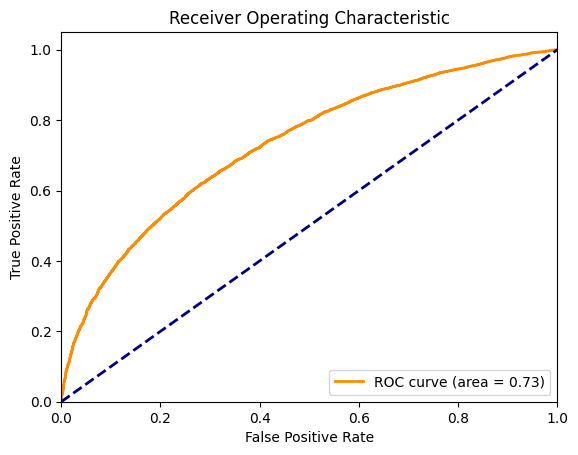

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 원본 데이터와 생성된 데이터 로드
original_data = pd.read_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/adult.csv")
synthetic_data = pd.read_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/adult_output_CTGAN.csv")

# 라벨 추가 (원본 데이터: 0, 생성된 데이터: 1)
original_data['label'] = 0
synthetic_data['label'] = 1

# 두 데이터셋 결합
combined_data = pd.concat([original_data, synthetic_data], ignore_index=True)

# 범주형 컬럼과 연속형 컬럼 구분
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
numerical_columns = [col for col in combined_data.columns if col not in categorical_columns and col != 'label']

def preprocess_data(df):
    # 원-핫 인코딩
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_categorical = encoder.fit_transform(df[categorical_columns])

    # 연속형 데이터 스케일링
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(df[numerical_columns])

    # 인코딩된 데이터와 스케일된 데이터 합치기
    X = np.hstack((encoded_categorical, scaled_numerical))
    y = df['label'].values

    return X, y

X, y = preprocess_data(combined_data)

# 학습용과 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 분류기 학습
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 결과 출력
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC AUC Score: {roc_auc}')

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


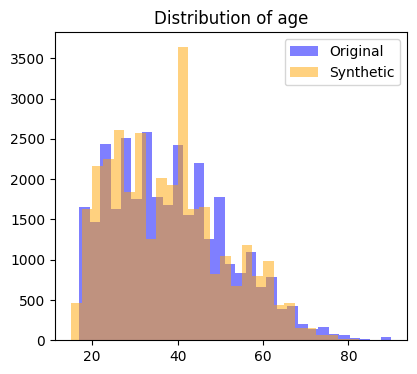

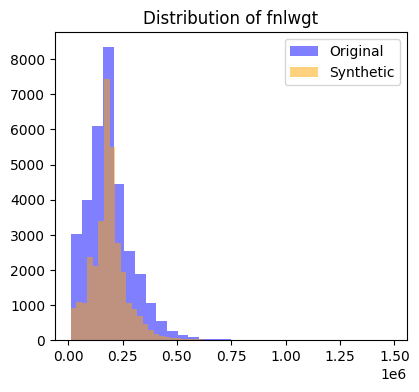

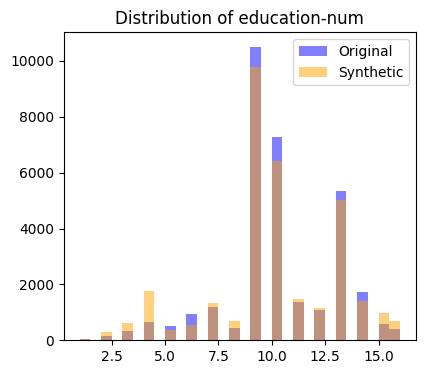

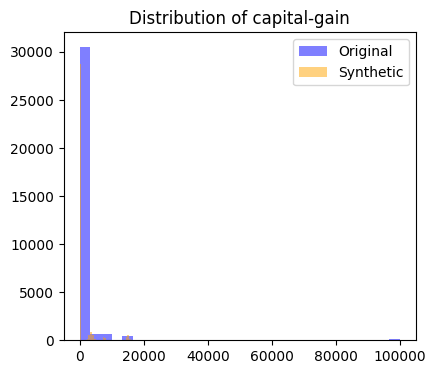

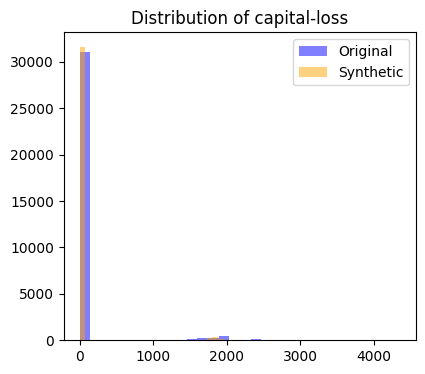

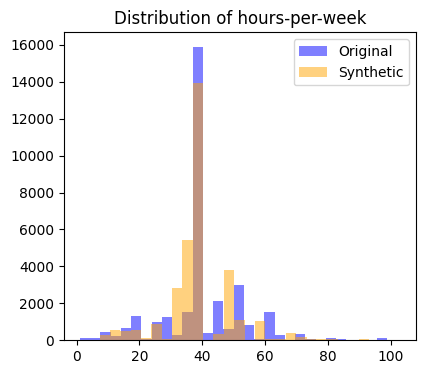

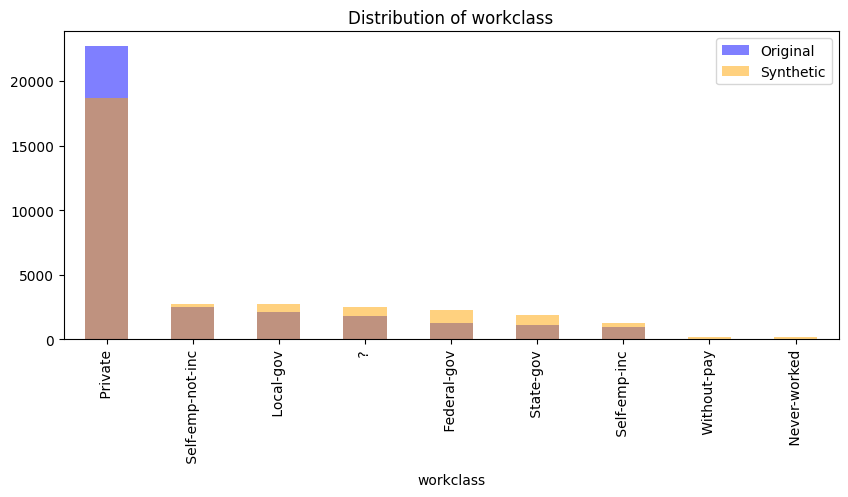

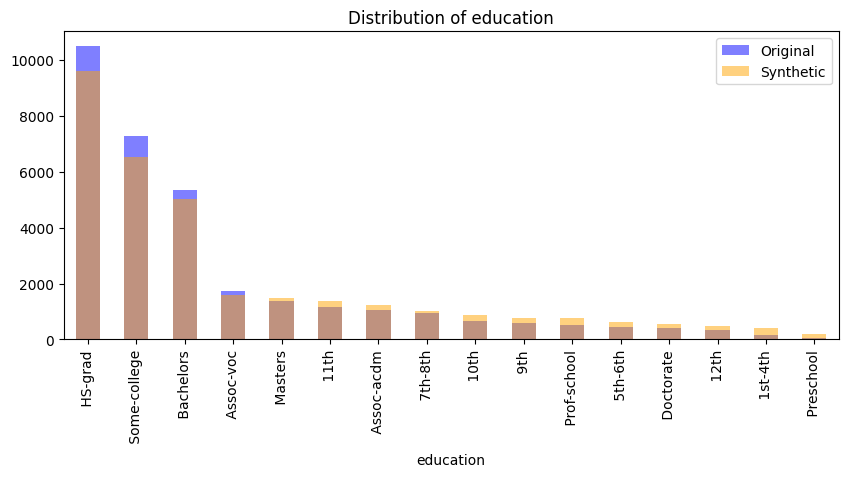

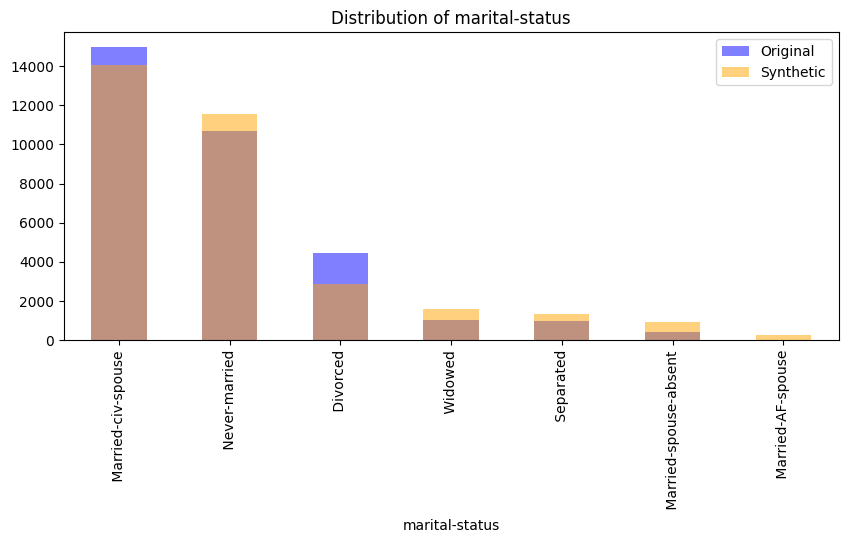

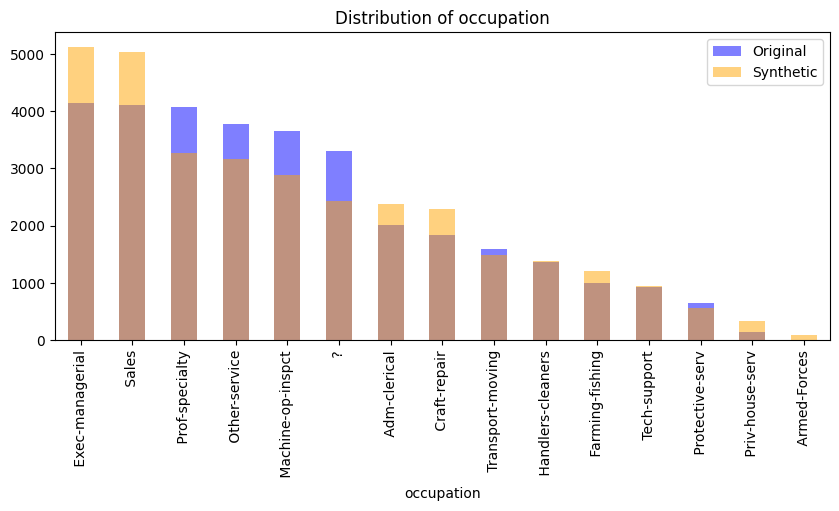

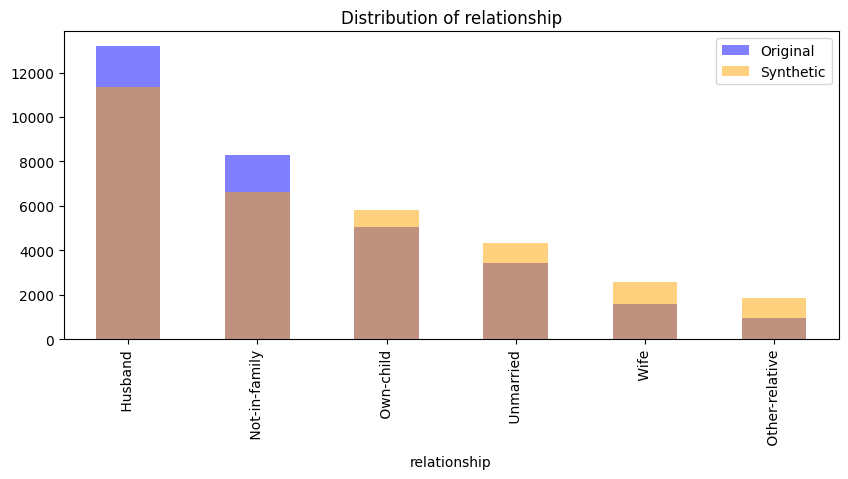

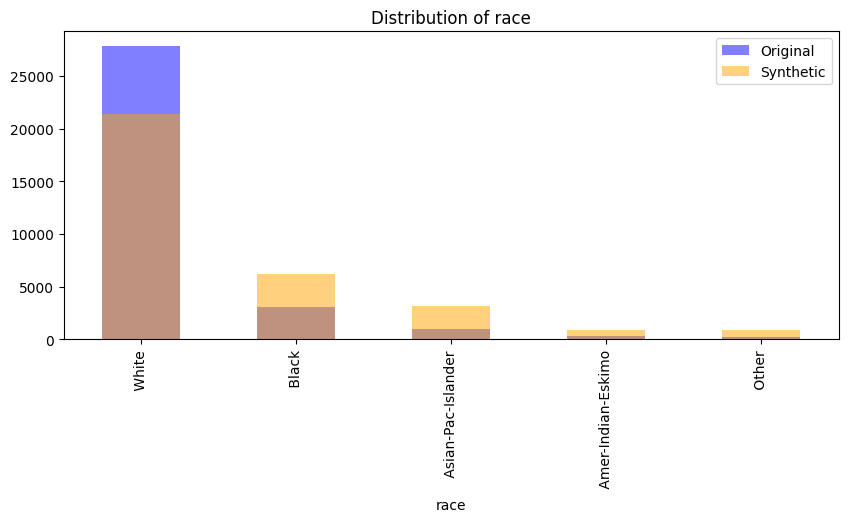

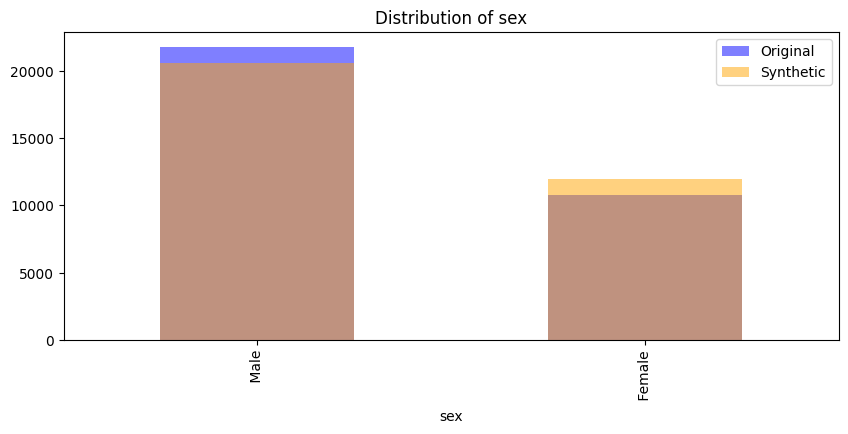

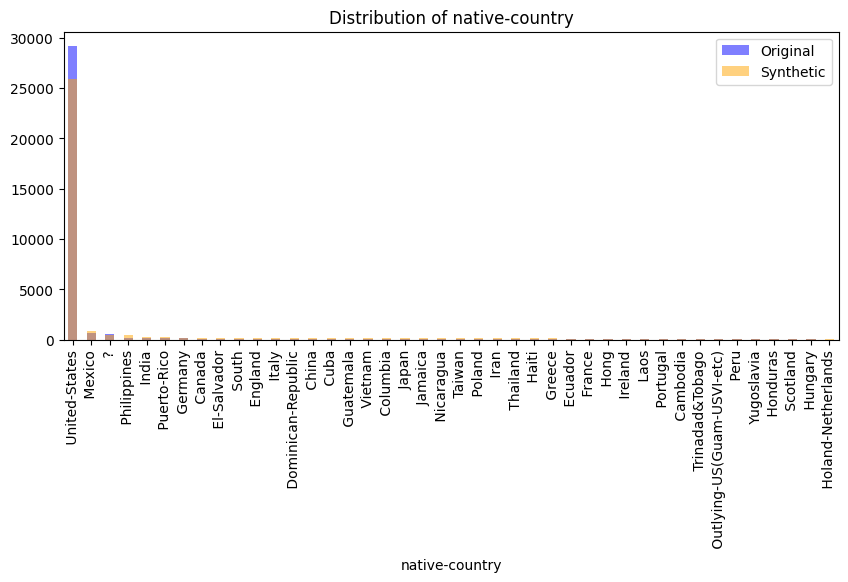

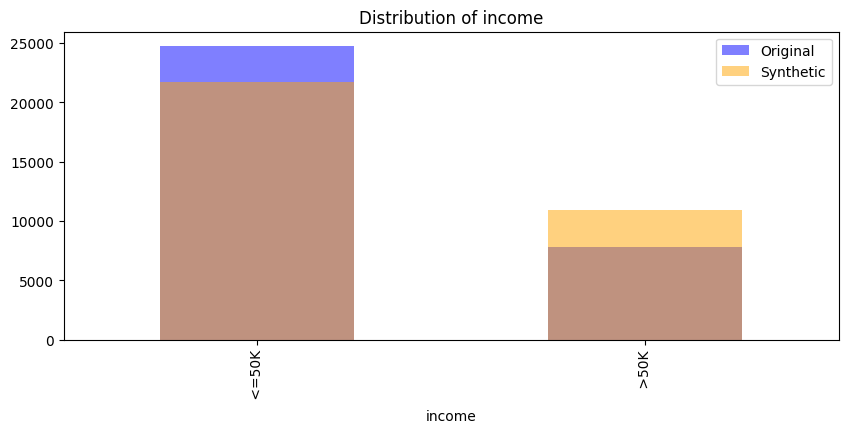

In [17]:
import matplotlib.pyplot as plt

# 데이터 분포 시각화
def plot_distributions(original, synthetic, columns, kind='hist'):
    for col in columns:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        if kind == 'hist':
            plt.hist(original[col], bins=30, alpha=0.5, label='Original', color='blue')
            plt.hist(synthetic[col], bins=30, alpha=0.5, label='Synthetic', color='orange')
        elif kind == 'box':
            plt.boxplot([original[col], synthetic[col]], labels=['Original', 'Synthetic'])
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

# 연속형 데이터 분포 시각화
plot_distributions(original_data, synthetic_data, numerical_columns, kind='hist')

# 범주형 데이터 분포 시각화
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    original_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Original', color='blue')
    synthetic_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Synthetic', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()
